# Training a scikit-learn model for node classification

After extrating target class (isUSCitizen) and features (number of movies and louvain community) from Neo4j, we train a scikit-learn classification model to predict the target class.


In [1]:
import pandas as pd
from graphdatascience import GraphDataScience

from sklearn.utils import resample
from sklearn import tree, metrics, ensemble
from sklearn.model_selection import train_test_split


gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "admin"))

In [2]:
data = gds.run_cypher(
    """MATCH (person:Person:MainComponent)-[:IS_CITIZEN_OF]->(country:Country)
    WITH person, collect(country.name) as countries
    MATCH (person)-[:ACTED_IN|DIRECTED]->(movie:Movie)
    WITH person, countries, count(DISTINCT movie) as numberOfMovies
    RETURN  id(person) as id, 
            'United States of America' IN countries as target,
            numberOfMovies as nbMovies, 
            person.louvain as louvain
    """
)
data.head()

,id,target,nbMovies,louvain
0,14042,False,2,17967
1,46793,True,3,3831
2,46686,False,1,3486
3,43955,False,1,15347
4,43953,False,1,15347


In [3]:
len(data)

21296

In [4]:
data.target.value_counts()

False    13687
True      7609
Name: target, dtype: int64

In [5]:
true_data = data[data.target == 1]
false_data = data[data.target == 0]
len(true_data), len(false_data)

(7609, 13687)

In [6]:
false_data_downsampled = resample(
    false_data,
    replace=False,
    n_samples=len(true_data),
    random_state=1234,
)

In [7]:
data = pd.concat([true_data, false_data_downsampled], axis=0)
data.target.value_counts()

True     7609
False    7609
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

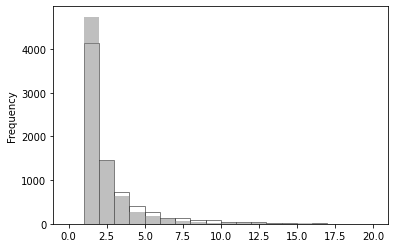

In [8]:
true_data["nbMovies"].plot.hist(range=(0, 20), bins=20, color="white", edgecolor="black", alpha=0.5)
false_data_downsampled["nbMovies"].plot.hist(range=(0, 20), bins=20, color="grey", alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

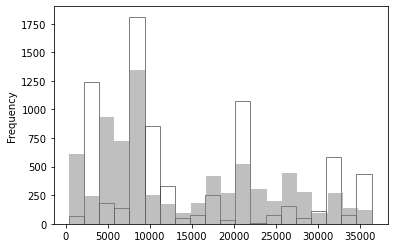

In [9]:
true_data["louvain"].plot.hist(bins=20, color="white", edgecolor="black", alpha=0.5)
false_data_downsampled["louvain"].plot.hist(bins=20, color="grey", alpha=0.5)

In [10]:
def train_and_score(X_train, y_train, X_test, y_test, feature_columns):
    X_train_bis = X_train[feature_columns]
    X_test_bis = X_test[feature_columns]
    clf = tree.DecisionTreeClassifier()
    # clf = ensemble.RandomForestClassifier()
    clf = clf.fit(X_train_bis, y_train)
    return clf, clf.score(X_test_bis, y_test)

In [11]:
X = data[["nbMovies", "louvain"]]
y = data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33,
    stratify=data.target,
    random_state=1234
)
len(X_train), len(X_test)

(10196, 5022)

In [12]:
feature_sets = [
   ["nbMovies"],
   ["nbMovies", "louvain"],
]

for feature_set in feature_sets:
    clf, score = train_and_score(
        X_train, y_train, X_test, y_test, 
        feature_set
    )
    
    print(f"{str(feature_set):30} => {score:2.3f}")

['nbMovies']                   => 0.543
['nbMovies', 'louvain']        => 0.808
